#### 0. import necessary torch package

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

#### 1. pre-load dataset (CIFAR-10)

note 1. Data augemtation is beneficial to increasing model's performance (8% increase in test data set)

In [67]:
# data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.45), (0.2, 0.2, 0.2)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.45), (0.2, 0.2, 0.2)),
])

# no data augmentation
transform = transforms.Compose([
    transforms.ToTensor(), 
    #transforms.Normalize((0.5, 0.5, 0.45), (0.2, 0.2, 0.2))
])


# download data set
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

# define data loader
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


#### 2. train ResNet-18 module

In [2]:
import torch.nn as nn
import torch.optim as optim
from OurResNet import OurResNet18

##### 2.1 define resnet18

In [3]:
# check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OurResNet18 = OurResNet18()
OurResNet18 = OurResNet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(OurResNet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# Adamoptimizer  = optim.Adam(OurResNet18.parameters(), lr=0.1, betas=(0.9, 0.99))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, verbose=1, patience=5)

writer = SummaryWriter("./runs/ours/SGD/4")

##### 2.2 train process

In [4]:
def train(dataloader, model, loss_fn, optimizer, epochs):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss, correct = 0, 0 

    for batch, (inputs, labels) in enumerate(dataloader):
       
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # compute the forward error
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # backpropagation
        loss.backward()
        optimizer.step()
        
        # compute the train loss
        preds = model(inputs)
        train_loss += loss_fn(preds, labels).item()
        correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
        
        # print loss
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    correct /= size
    writer.add_scalar("train loss", train_loss, epochs)
    writer.add_scalar("train accuracy", correct, epochs)
    

##### 2.3 test process

In [5]:
def test(dataloader, model, loss_fn, epochs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # predict
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).item()
            
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size

    scheduler.step(correct)
    
    writer.add_scalar("test loss", test_loss, epochs)
    writer.add_scalar("test accuracy", correct, epochs)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

##### 2.4 begin training

note 2.  learning rate decay is essential (3% increase in test data set)

In [40]:
epochs = 100
for i in range(100):
    print(f"Epoch {i+1}/{epochs}\n------------------------------")
    train(trainloader, OurResNet18, criterion, optimizer, i)
    print(f"Finishing train--------------------------- ")
    test(testloader, OurResNet18, criterion, i)
print("ALL done--------------------------")

writer.close()

Epoch 1/60
------------------------------
loss: 2.415158  [  128/50000]
loss: 2.010253  [12928/50000]
loss: 1.661100  [25728/50000]
loss: 1.601591  [38528/50000]
Finishing train--------------------------- 
Test Error: 
 Accuracy: 43.2%, Avg loss: 1.512102 

Epoch 2/60
------------------------------
loss: 1.546983  [  128/50000]
loss: 1.452048  [12928/50000]
loss: 1.189680  [25728/50000]
loss: 1.236261  [38528/50000]
Finishing train--------------------------- 
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.199258 

Epoch 3/60
------------------------------
loss: 0.996641  [  128/50000]
loss: 1.218633  [12928/50000]
loss: 1.017123  [25728/50000]
loss: 1.083184  [38528/50000]
Finishing train--------------------------- 
Test Error: 
 Accuracy: 61.1%, Avg loss: 1.085693 

Epoch 4/60
------------------------------
loss: 1.009930  [  128/50000]
loss: 1.050339  [12928/50000]
loss: 0.933996  [25728/50000]
loss: 0.899569  [38528/50000]
Finishing train--------------------------- 
Test Error: 
 Accura

KeyboardInterrupt: 

In [24]:
summary(OurResNet18, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

##### save model

In [33]:
torch.save(OurResNet18.state_dict(), "./OurResNet18.pth")

#### 3. predict output

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def imshow(img):
    #plt.figure(figsize=(5,5))
    img = img / 2 + 0.6     # unnormalize
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    plt.savefig("cifar10.pdf", bbox_inches='tight')

##### load model

In [12]:
model = OurResNet18.to(device)
model.load_state_dict(torch.load("./OurResNet18.pth"))




<All keys matched successfully>

##### 3.1 few samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


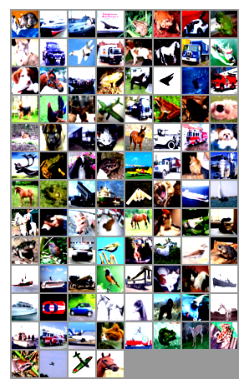

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  


<Figure size 640x480 with 0 Axes>

In [56]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(testloader)
images, labels = next(dataiter)
#imshow(images[1])
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [31]:
print(images[1].shape)

torch.Size([3, 32, 32])


In [12]:
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(64)))

Predicted:  horse ship  horse ship  frog  bird  car   dog   ship  bird  deer  car   dog   truck truck horse plane dog   bird  dog   ship  dog   ship  horse cat   ship  dog   truck frog  car   car   frog  truck cat   bird  plane deer  dog   car   ship  truck truck ship  dog   ship  dog   frog  bird  car   deer  horse ship  frog  truck truck horse plane horse car   horse dog   bird  horse plane


##### 3.2 each class

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 92.1 %
Accuracy for class: car   is 93.3 %
Accuracy for class: bird  is 89.1 %
Accuracy for class: cat   is 81.4 %
Accuracy for class: deer  is 92.0 %
Accuracy for class: dog   is 87.7 %
Accuracy for class: frog  is 93.3 %
Accuracy for class: horse is 95.6 %
Accuracy for class: ship  is 94.3 %
Accuracy for class: truck is 93.7 %


#### 4. 可视化

Files already downloaded and verified


KeyboardInterrupt: 

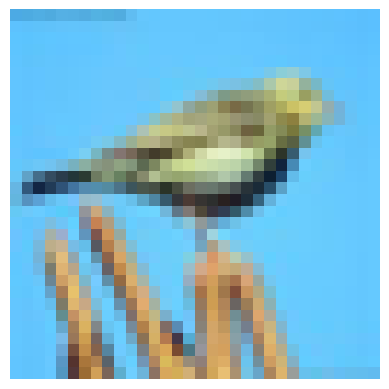

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 设置随机种子，以确保每次运行结果一致
torch.manual_seed(42)

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 获取CIFAR-10测试集
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 创建数据加载器
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# 获取所有测试集数据
all_images, all_labels = next(iter(test_loader))

# 创建一个字典来存储每个类别的图像索引
class_indices = {label: [] for label in range(10)}

# 根据标签将图像索引添加到字典
for i, label in enumerate(all_labels):
    class_indices[label.item()].append(i)

# 计算每个类别的最小图像数量
min_images_per_class = min(len(indices) for indices in class_indices.values())

# 将所有图像按照类别排布，每行为同一个类别
#fig, axes = plt.subplots( 10,min_images_per_class, figsize=(15, 15))

for i in range(10):
    for j in range(min_images_per_class):
        index = class_indices[i][j]
        image = np.transpose(all_images[index].numpy(), (1, 2, 0))
        plt.imshow(image)
        # img = img / 2 + 0.6     # unnormalize
        plt.axis('off')
        plt.savefig("{0}{1}.jpg".format(i, j), format='jpg' ,bbox_inches='tight')
plt.show()


truck


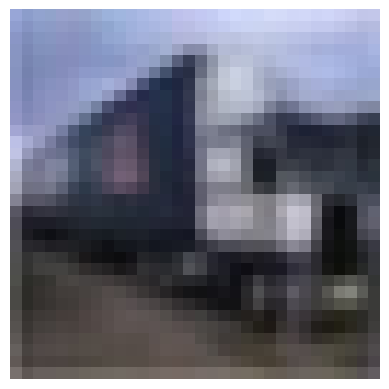

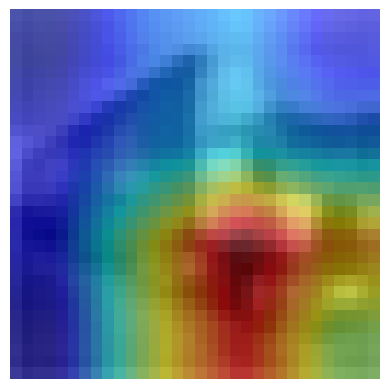

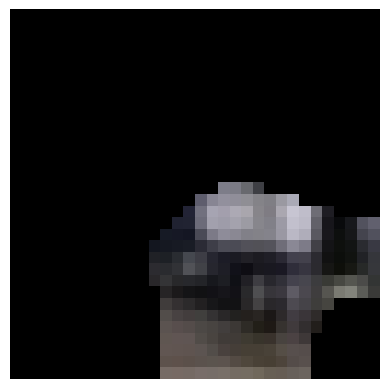

In [23]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = OurResNet18.to(device)
model.load_state_dict(torch.load("./OurResNet18.pth"))


#model = models.mobilenet_v3_large(pretrained=True)
target_layers = [model.layer4[-1]]

# model = models.vgg16(pretrained=True)
# target_layers = [model.features]

# model = models.resnet34(pretrained=True)
# target_layers = [model.layer4]

# model = models.regnet_y_800mf(pretrained=True)
# target_layers = [model.trunk_output]

# model = models.efficientnet_b0(pretrained=True)
# target_layers = [model.features]

data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.45), (0.2, 0.2, 0.2))])
# load image
img_path = "truck.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path).convert('RGB')
img = np.array(img, dtype=np.uint8)
# img = center_crop_img(img, 224)

# [C, H, W]
img_tensor = data_transform(img)

# expand batch dimension
# [C, H, W] -> [N, C, H, W]
input_tensor = torch.unsqueeze(img_tensor, dim=0)


cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
target_category = 9  # tabby, tabby cat
# target_category = 254  # pug, pug-dog

input_tensor=input_tensor.to(device)
output = model(input_tensor)
_,predicted = torch.max(output, 1)
# print(predicted)
print(classes[predicted])

grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

grayscale_cam = grayscale_cam[0, :]
#print(grayscale_cam)
visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                    grayscale_cam,
                                    use_rgb=True)

plt.imshow(img)
plt.axis("off")
plt.show()

plt.imshow(visualization)
plt.axis("off")
plt.show()
gray_map = np.zeros((32, 32, 3))
#print(gray_map.shape)
gray_map[:,:,0] = grayscale_cam
gray_map[:,:,2] = grayscale_cam
gray_map[:,:,1] = grayscale_cam
gray_map = (gray_map > 0.6)

#print(gray_map)
plt.imshow(img*gray_map)
plt.axis("off")
plt.show()

reference


[1] https://blog.csdn.net/weixin_42899627/article/details/108542019